#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

# План проекта:
1. Загрузим и изучим данные. 
2. Проанализируем данные, подготовим их к обучению моделей.
3. Подготовим выборки для обучения моделей.
4. Обучим разные модели: линейную регрессию, Случайный лес, библиотеки градиентного бустинга CatBoost,GradientBoostingRegressor и LightGBM.
5. Для каждой модели попробуем разные гиперпараметры.
6. Проанализируем качество моделей.
7. Выберем лучшую модель, проверим её качество на тестовой выборке.

## Подготовка

In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from numpy.random import RandomState
state = np.random.RandomState(12345)

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV

from sklearn.datasets import make_regression

from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

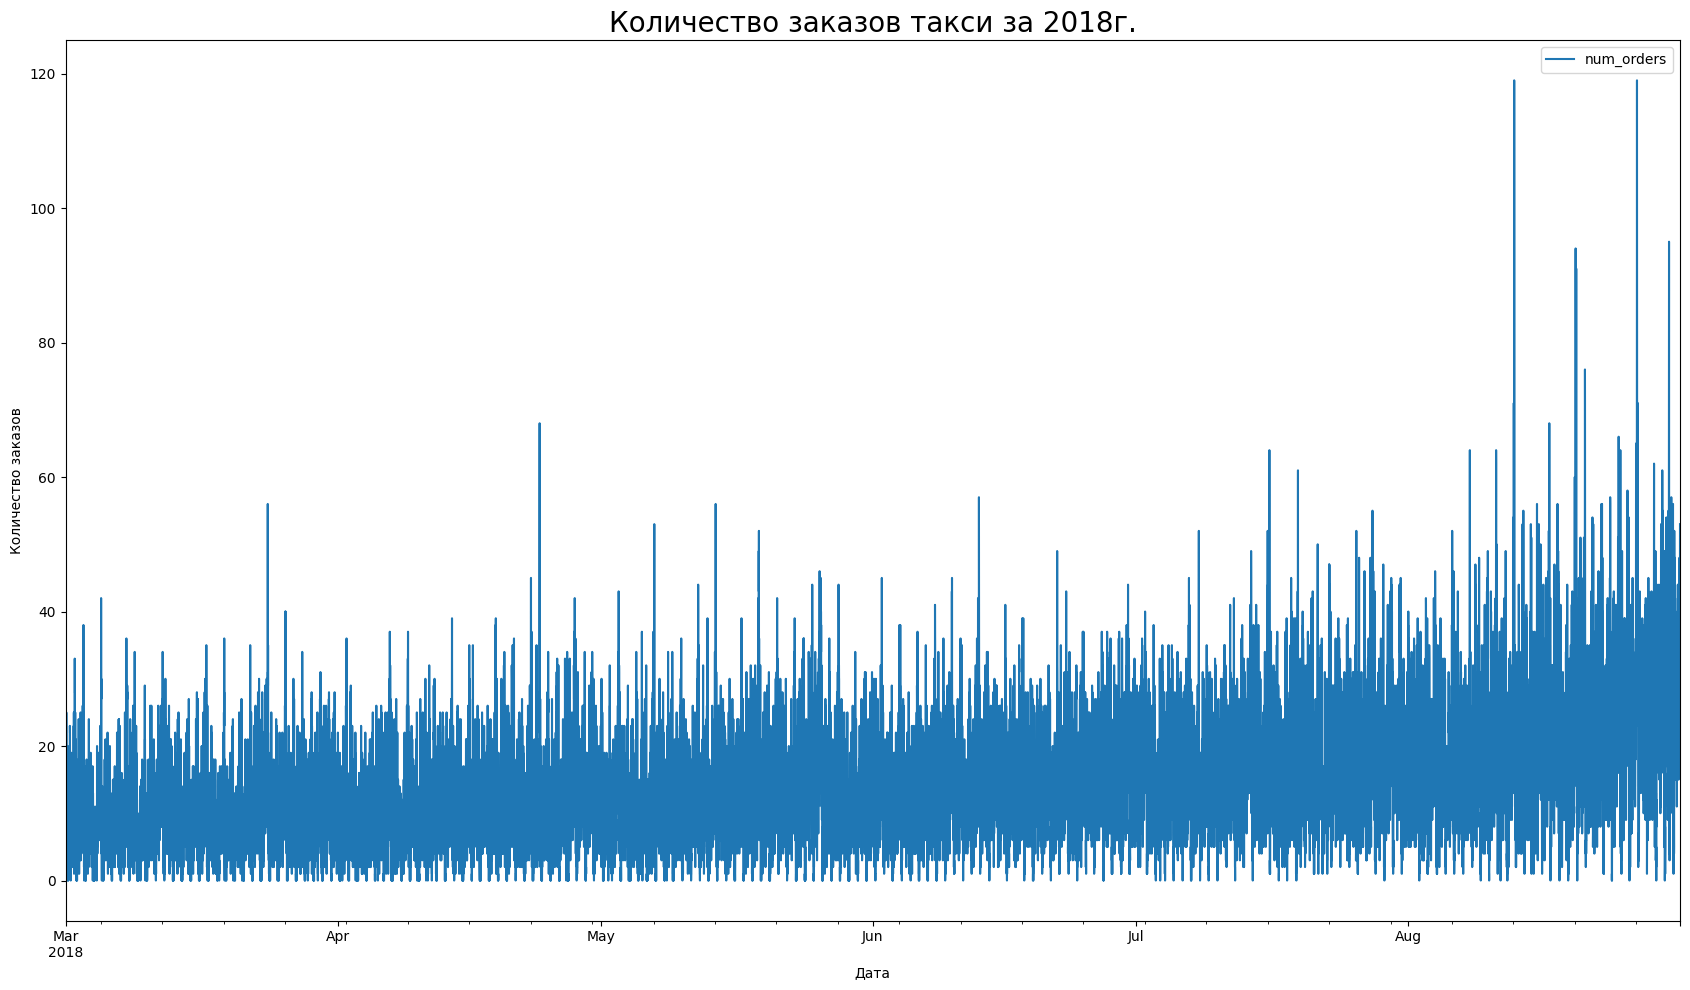

In [3]:
plt.figure(figsize=(17,10))
plt.subplot()
data.plot(ax=plt.gca())

plt.xlabel("Дата")
plt.ylabel("Количество заказов")
plt.title('Количество заказов такси за 2018г.', fontsize=20)

plt.tight_layout()

In [4]:
print('Количество стобцов:', data.shape[1])
print('Количество строк:', data.shape[0])
display(data.head())

Количество стобцов: 1
Количество строк: 26496


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
print('Дата начала выборки', data.index.min())
print('Дата окончания выборки', data.index.max())

Дата начала выборки 2018-03-01 00:00:00
Дата окончания выборки 2018-08-31 23:50:00


In [8]:
# Проверим на наличие пропущенных значений
print('Всего пропущенных значений:', data.isnull().sum())

Всего пропущенных значений: num_orders    0
dtype: int64


In [9]:
data = data.resample('1H').sum()

In [10]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [11]:
data.tail()

,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


Данные загружены и изучены. В выборке мы имеем данные с 01 марта 2018 года по 31 августа 2018 года. Пропущенных значений нет. Выполнено ресемплирование данных по одному часу.

## Анализ

In [12]:
# Рассмотрим тренд, сезонность и остатки декомпозоции
decomposed = seasonal_decompose(data) 

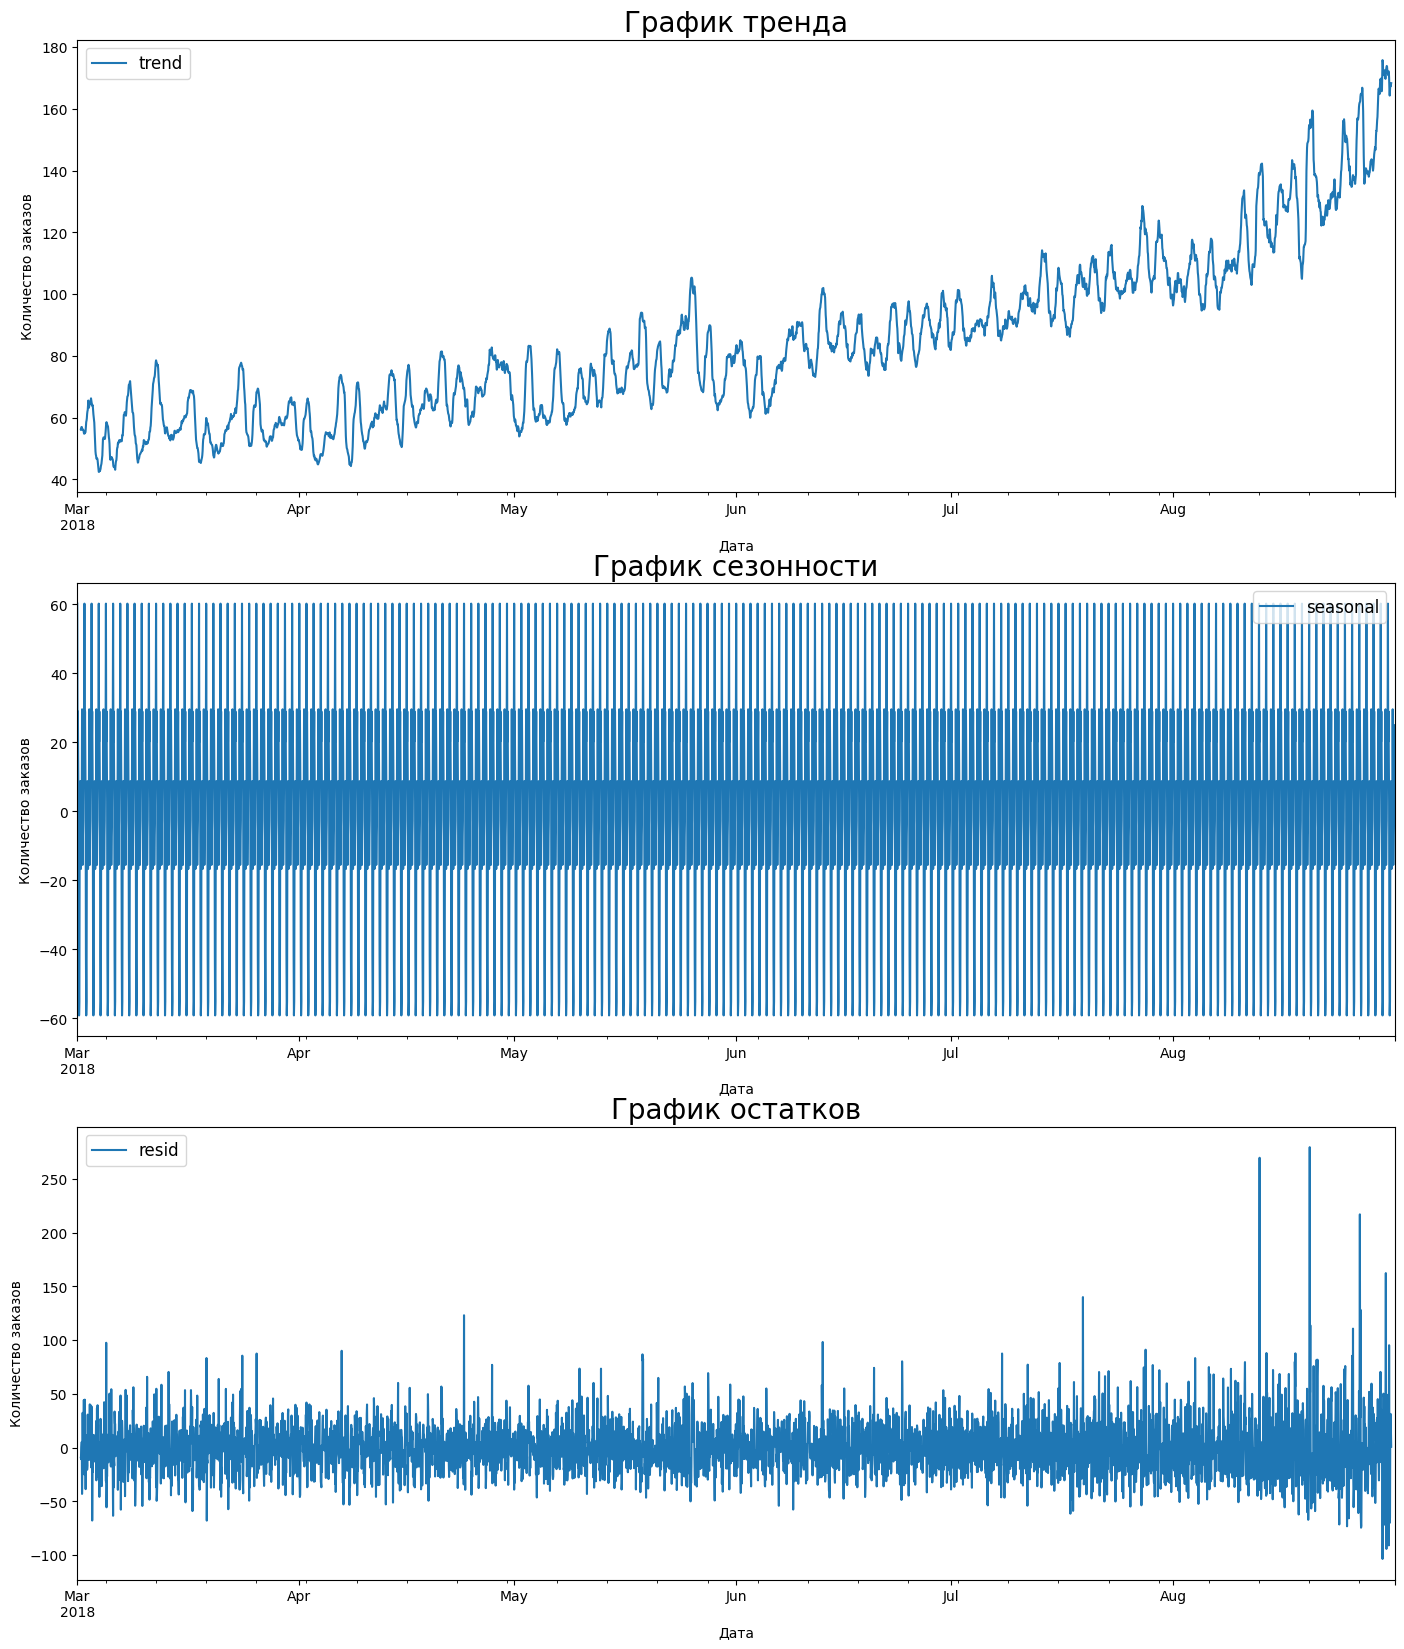

In [13]:
# Построим графики тренда, сезонности и остатков
plt.figure(figsize=(17,20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('График тренда', fontsize=20)
plt.xlabel("Дата")
plt.ylabel("Количество заказов")
plt.legend(fontsize=12)
    
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('График сезонности', fontsize=20)
plt.xlabel("Дата")
plt.ylabel("Количество заказов")
plt.legend(fontsize=12)

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('График остатков', fontsize=20)
plt.xlabel("Дата")
plt.ylabel("Количество заказов")
plt.legend(fontsize=12)
# plt.tight_layout()
plt.show()

Чтобы во временном ряду снизить колебания, применим скользящее среднее.
Скользящее среднее (англ. rolling mean), или движущееся среднее (англ. moving average), — метод сглаживания временных рядов. Его суть заключается в поиске значений, которые меньше всего подвержены колебаниям, то есть средних арифметических.

In [14]:
data['mean'] = data['num_orders'].rolling(15).mean()
data['std'] = data['num_orders'].rolling(15).std()

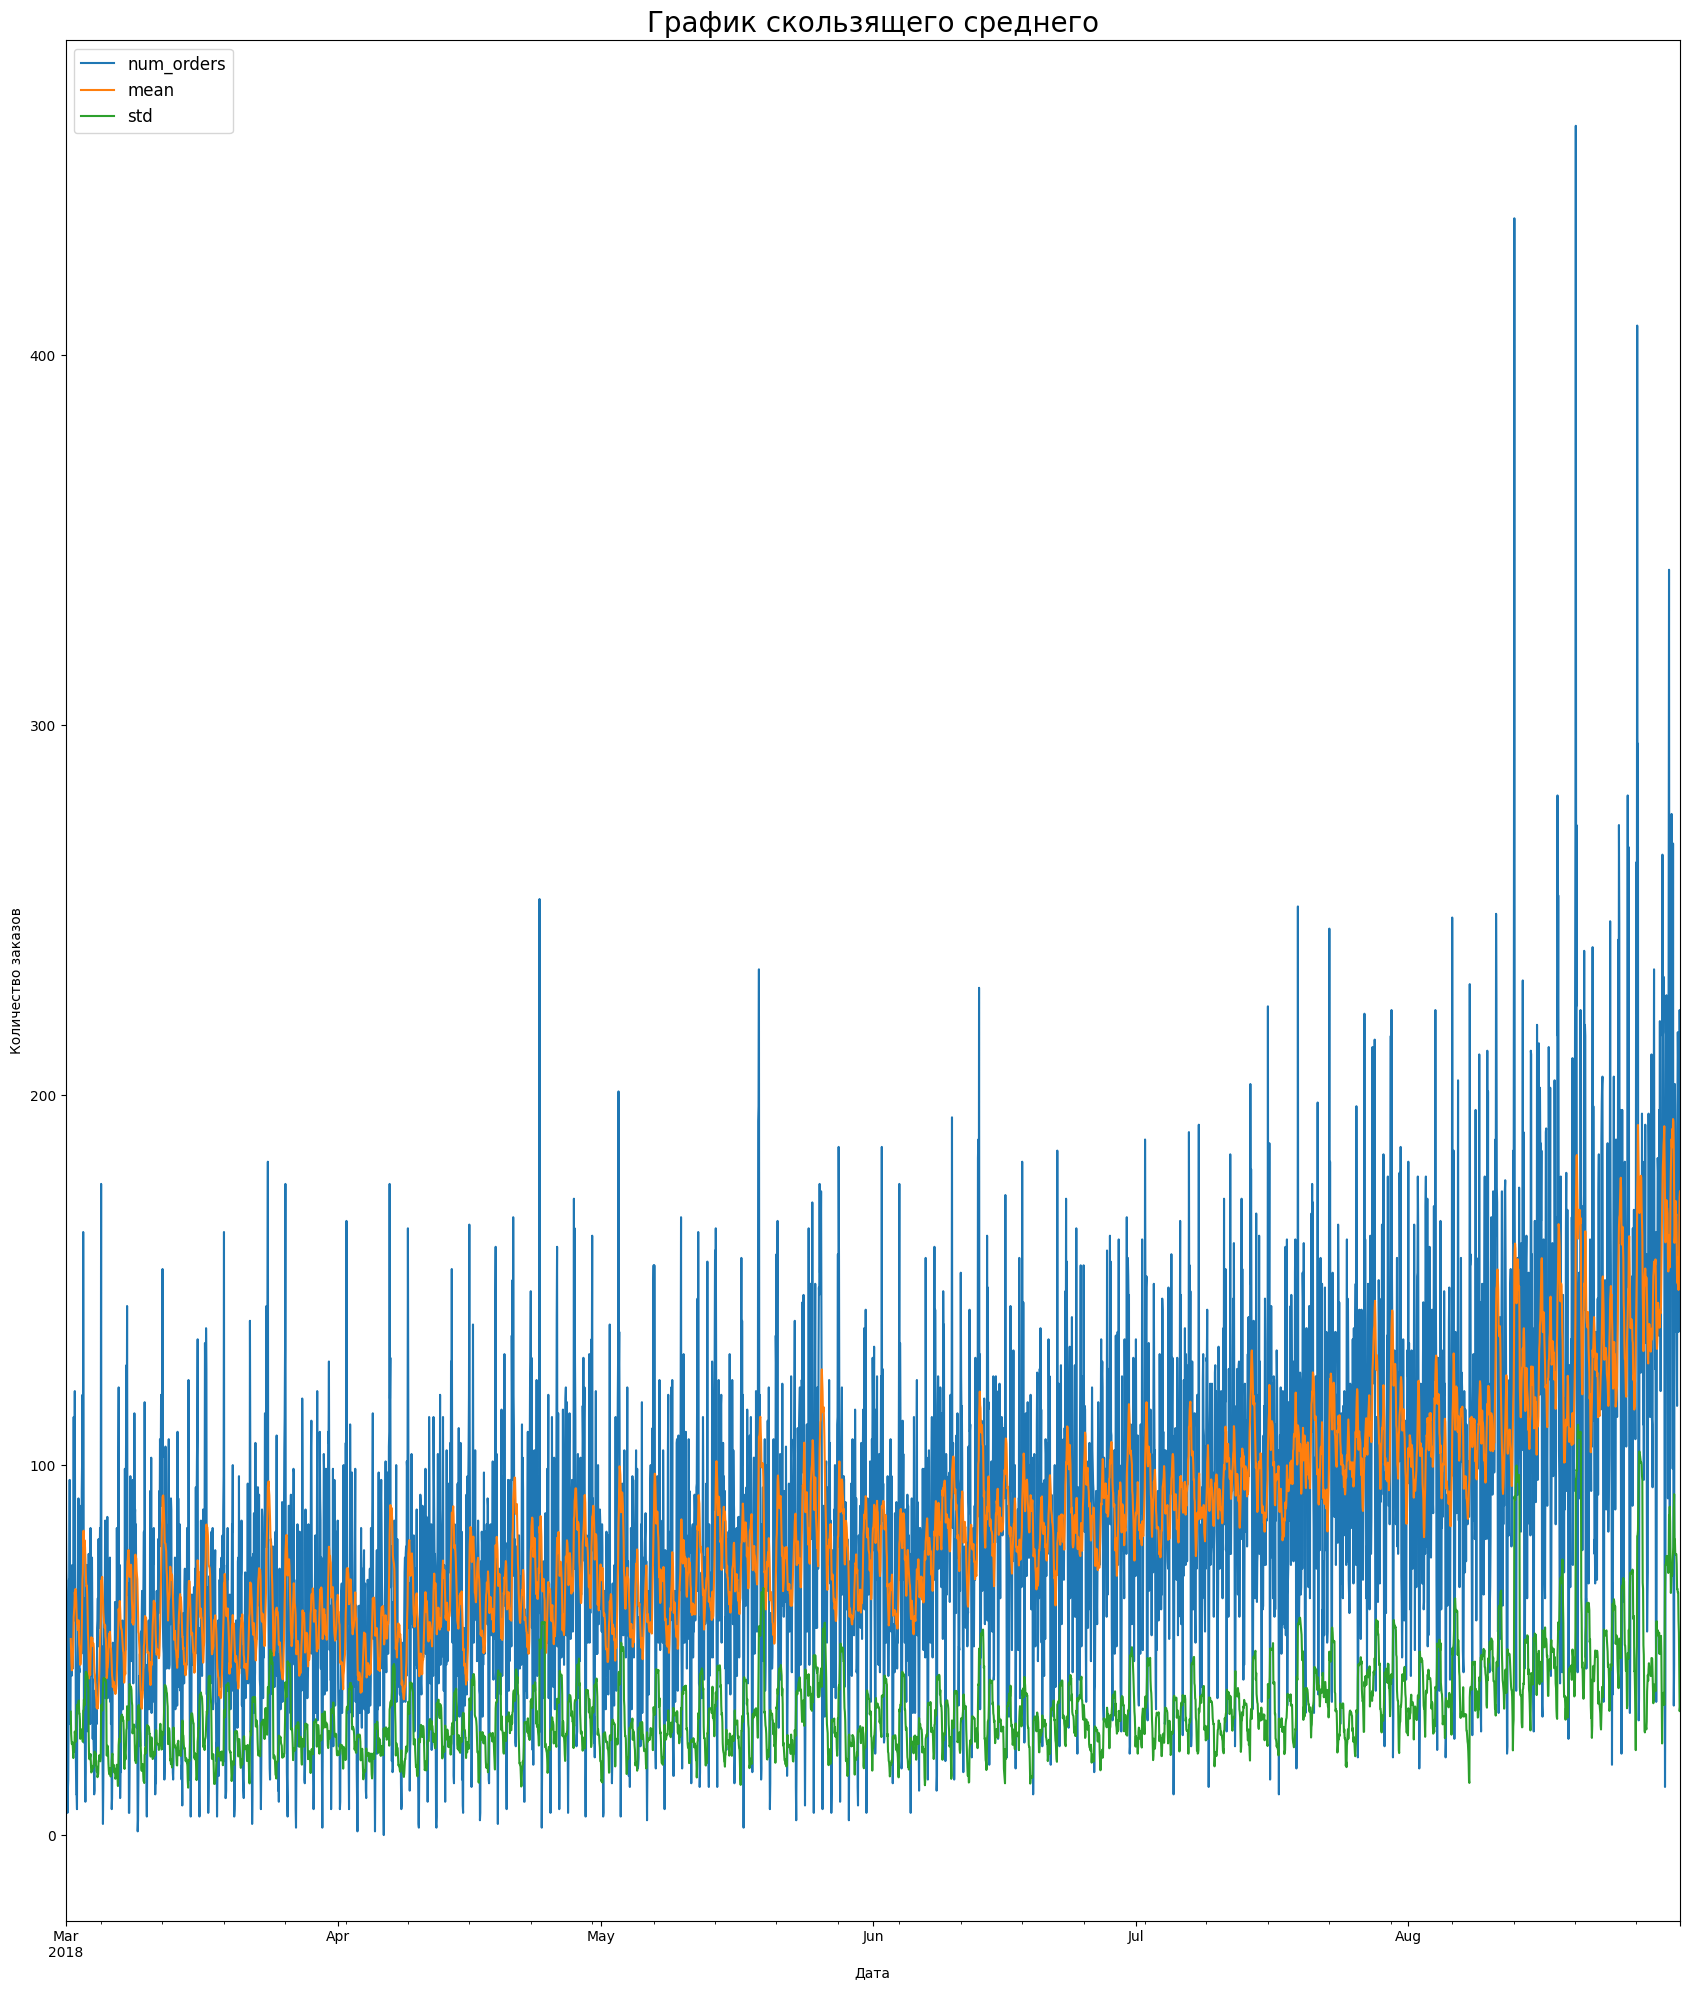

In [15]:
plt.figure(figsize=(17,20))
plt.subplot()
data.plot(ax=plt.gca())

plt.xlabel("Дата")
plt.ylabel("Количество заказов")
plt.title('График скользящего среднего', fontsize=20)

plt.legend(fontsize=12)
plt.tight_layout()

Чтобы ряд сделать стационарным, найдём разности его значений.

In [16]:
data = data - data.shift(fill_value=0)
data['mean'] = data['num_orders'].rolling(15).mean()
data['std'] = data['num_orders'].rolling(15).std()

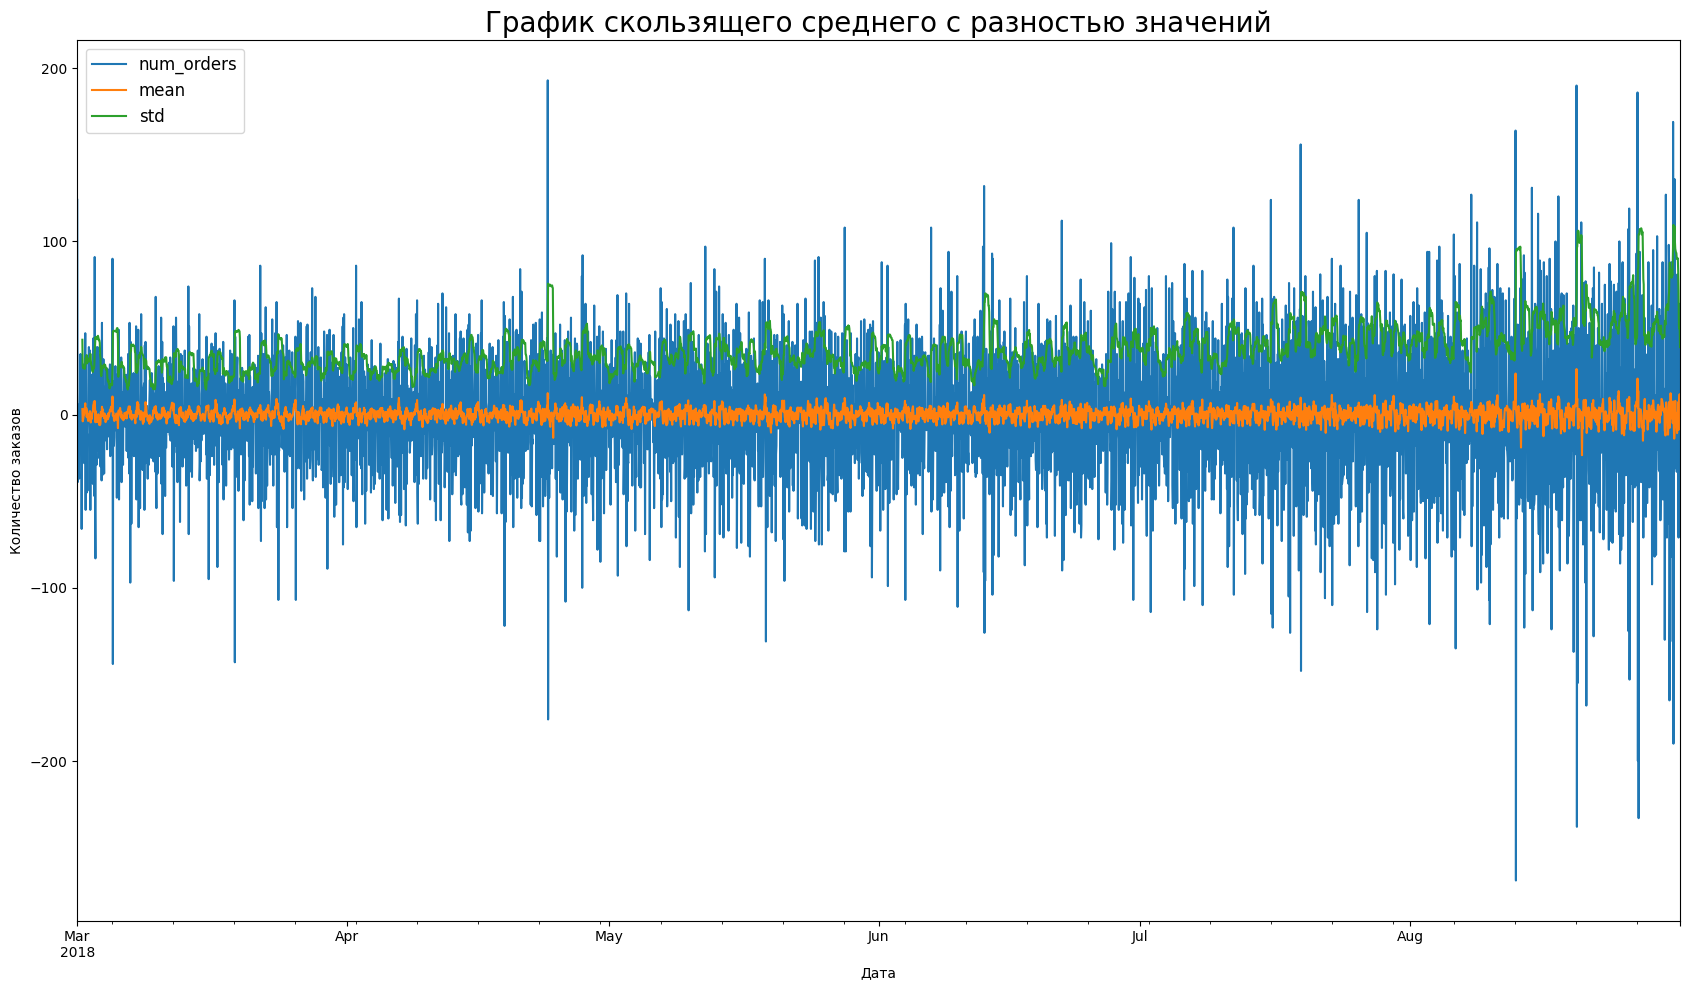

In [17]:
plt.figure(figsize=(17,10))
plt.subplot()
data.plot(ax=plt.gca())

plt.xlabel("Дата")
plt.ylabel("Количество заказов")
plt.title('График скользящего среднего с разностью значений', fontsize=20)

plt.legend(fontsize=12)
plt.tight_layout()

Проведем проверку на стационарность ряда

In [18]:
test = sm.tsa.adfuller(data['num_orders'])
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -15.79475911148109
p-value:  1.0915609954401546e-28
Critical values:  {'1%': -3.4318425029781716, '5%': -2.862199504531929, '10%': -2.5671210585627398}
единичных корней нет, ряд стационарен


Вывод по этапу 2. Проанализировали данные, привели ряд к стационарному. Можно обучать модели.

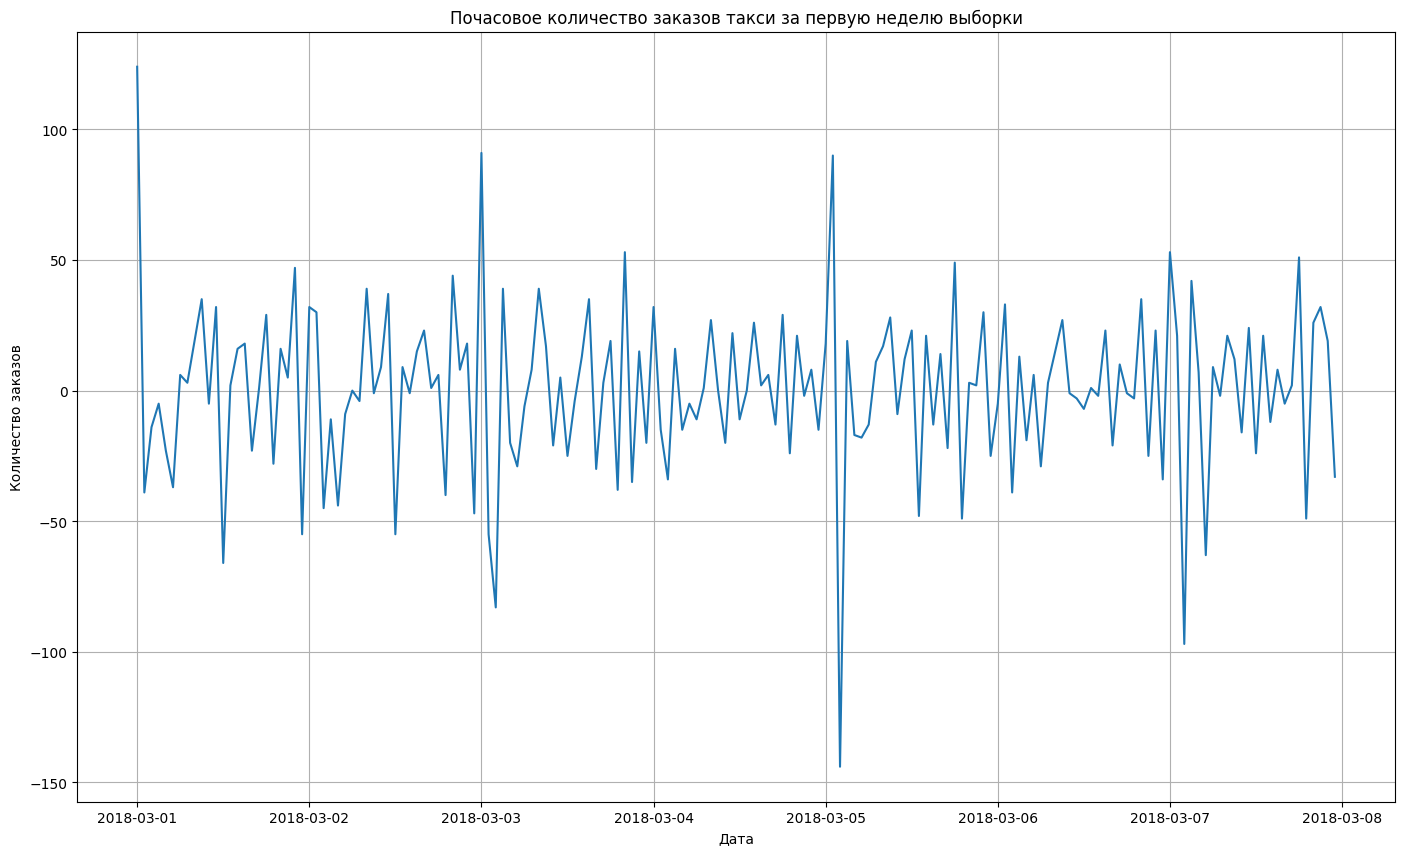

In [19]:
# Посмотрим на данные первой недели выборки
fig, ax = plt.subplots(figsize=(17, 10))

ax.plot(data['num_orders']['2018-03-01':'2018-03-07'])
ax.grid()

#  Добавляем подписи к осям:

ax.set(xlabel="Дата",
       ylabel="Количество заказов",
       title="Почасовое количество заказов такси за первую неделю выборки")

plt.show()

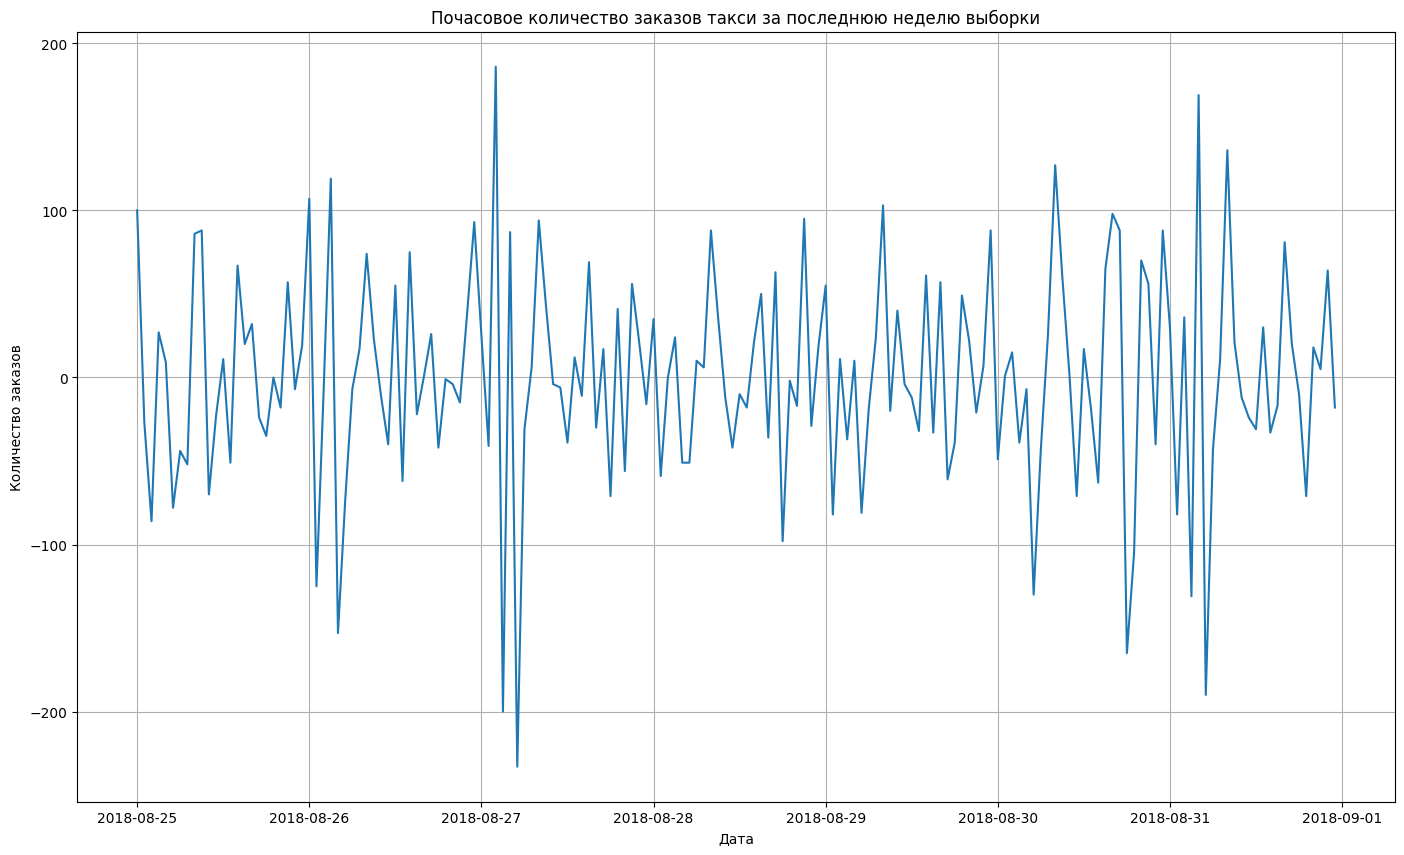

In [20]:
# Посмотрим на данные последней недели выборки
fig, ax = plt.subplots(figsize=(17, 10))

ax.plot(data['num_orders']['2018-08-25':'2018-08-31'])
ax.grid()

#  Добавляем подписи к осям:

ax.set(xlabel="Дата",
       ylabel="Количество заказов",
       title="Почасовое количество заказов такси за последнюю неделю выборки")

plt.show()

## Обучение

In [21]:
# Напишем функцию для создания признаков.
data_make_features = data.copy()

def make_features(data, max_lag, rolling_mean_size):
    
    data_make_features['year'] = data_make_features.index.year
    data_make_features['month'] = data_make_features.index.month
    data_make_features['day'] = data_make_features.index.day
    data_make_features['dayofweek'] = data_make_features.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data_make_features['lag_{}'.format(lag)] = data_make_features['num_orders'].shift(lag)

    data_make_features['rolling_mean'] = data_make_features['num_orders'].shift().rolling(rolling_mean_size).mean()

In [22]:
# Создадим пустой Датафрем для записи результатов
data_analys = pd.DataFrame(columns = ['LinearRegression', 'RandomForestRegressor', 
                          'CatBoostRegressor', 'GradientBoostingRegressor'], 
                           index=['RMSE', 'RMSE с подбором параметров'
                                 ])

In [23]:
# Создадим признаки
make_features(data_make_features, 6, 6)

In [24]:
# Создадим тестовую выборку размером 10% от исходных данных.
# Разделим тренировочную выборку для валидации моделей

train, test = train_test_split(data_make_features, shuffle=False, random_state=state, test_size=0.1)
train, valid = train_test_split(train, shuffle = False, random_state=state, test_size = 0.25)

print('Размер тренировочной выборки:', train.shape)
print('Размер валидационной выборки:', valid.shape)
print('Размер тестовой выборки:', test.shape)

Размер тренировочной выборки: (2980, 14)
Размер валидационной выборки: (994, 14)
Размер тестовой выборки: (442, 14)


In [25]:
# Создим признаки и целевые признаки.

train = train.dropna()

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_valid = valid.drop('num_orders', axis=1)
y_valid = valid['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

### Модель линейная регрессия

In [26]:
model = LinearRegression().fit(X_train, y_train)
predict_train = model.predict(X_valid)
data_analys.loc['RMSE', 'LinearRegression'] = np.sqrt(mean_squared_error(y_valid, predict_train))

In [27]:
tscv = TimeSeriesSplit(n_splits=5)

In [28]:
# Модель линейной регрессии с кросс-валидацией
model_lr_cv = LinearRegression()
mse_lr_cv = (cross_val_score(model_lr_cv, 
                          X_train,
                          y_train,
                          cv=tscv,
                          scoring='neg_mean_squared_error').mean()
            )
data_analys.loc['RMSE с подбором параметров', 'LinearRegression'] = np.sqrt(abs(mse_lr_cv)) 

### Модель случайного леса

In [29]:
# Случайный лес на дефолтных параметрах
model_forest = RandomForestRegressor(random_state=state) 
model_forest.fit(X_train, y_train) 
predictions_forest = model_forest.predict(X_valid)
data_analys.loc['RMSE', 'RandomForestRegressor'] = np.sqrt(mean_squared_error(y_valid, predictions_forest))

In [30]:
%%time
# Подберем гиперпараметры
model_forest_params = {'max_depth': range(1, 25, 5),
               'n_estimators': range(50, 250, 15)}
model_forest = GridSearchCV(RandomForestRegressor(random_state=state), 
                         model_forest_params, 
                         cv=tscv, 
                         n_jobs=-1,
                         scoring='neg_mean_squared_error').fit(X_train, y_train)
predictions_rfr = model_forest.predict(X_valid)
data_analys.loc['RMSE с подбором параметров', 'RandomForestRegressor'] = np.sqrt(
    mean_squared_error(y_valid, predictions_rfr))

CPU times: total: 9.22 s
Wall time: 2min 1s


### Модель CatBoostRegressor

In [31]:
# Проверим модель на дефолтных параметрах

model_cbr = CatBoostRegressor(
   loss_function='RMSE'
).fit(X_train, y_train, verbose=False)

In [32]:
predictions = model_cbr.predict(X_valid)

data_analys.loc['RMSE', 'CatBoostRegressor']= np.sqrt(mean_squared_error(y_valid, predictions))

Попробуем изменить гиперпараметры

In [33]:
%%time

model_cbr_tune = CatBoostRegressor(loss_function='RMSE')

parameters_cbr_tune = {'iterations': [1000],
        'learning_rate': [0.03, 0.1],
        'depth': [6, 8],
#         'l2_leaf_reg': [1, 3]
              }
model_cbr_tune = GridSearchCV(model_cbr_tune, 
                        parameters_cbr_tune, 
                        cv = tscv, 
                        n_jobs=-1,
                              scoring = 'neg_mean_squared_error',
                             verbose=True).fit(X_train, y_train, 
                                               verbose=False)

predictions = model_cbr_tune.predict(X_valid)
data_analys.loc['RMSE с подбором параметров', 'CatBoostRegressor']= np.sqrt(mean_squared_error(y_valid, predictions))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
CPU times: total: 4.84 s
Wall time: 30.9 s


### Модель LightGBM

Очень долго подбирает параметры

In [34]:
# # Проверим модель на дефолтных параметрах

# model_lgb = LGBMRegressor()

In [35]:
# %%time

# model_lgb.fit(X_train, y_train)

In [36]:
# predictions = model_lgb.predict(X_valid)
# data_analys.loc['RMSE', 'LGBMRegressor']= np.sqrt(mean_squared_error(y_valid, predictions))

Попробуем изменить гиперпараметры

In [37]:
# parameters_grid = {'max_depth': [6],# 8],
#                    'learning_rate': [0.01],# 0.1],
#                   }

In [38]:
# %%time

# model_lgb_tuned = GridSearchCV(model_lgb, 
#                                parameters_grid, 
#                                scoring='neg_mean_squared_error',
#                                cv=tscv).fit(X_train, y_train)

# predictions = model_lgb_tuned.predict(X_valid)
# data_analys.loc['RMSE с подбором параметров', 'LGBMRegressor']= np.sqrt(mean_squared_error(y_valid, predictions))

### Модель GradientBoostingRegressor

In [40]:
params = {'n_estimators':200,
          'max_depth':12,
          'criterion':'friedman_mse',
          'learning_rate':0.03,
          'min_samples_leaf':16,
          'min_samples_split':16
          }
model_gbr = GradientBoostingRegressor(**params).fit(X_train, y_train)

In [41]:
predictions = model_gbr.predict(X_valid)
data_analys.loc['RMSE', 'GradientBoostingRegressor']= np.sqrt(mean_squared_error(y_valid, predictions))

Попробуем изменить гиперпараметры

In [42]:
parameters_grid = {'max_depth': [6, 8, 12],
                   'learning_rate': [0.01, 0.1],
                    }

In [43]:
model_gbr_tuned = GridSearchCV(model_gbr, 
                               parameters_grid, 
                               scoring='neg_mean_squared_error',
                               cv=tscv, verbose=True).fit(X_train, y_train)

predictions = model_gbr_tuned.predict(X_valid)
data_analys.loc['RMSE с подбором параметров', 'GradientBoostingRegressor']= np.sqrt(mean_squared_error(y_valid, predictions))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


## Тестирование

In [44]:
data_analys = data_analys.astype(float)
data_analys.T.style.highlight_min(color="yellow")

,RMSE,RMSE с подбором параметров
LinearRegression,30.400780,24.992259
RandomForestRegressor,29.851990,29.487776
CatBoostRegressor,27.456869,27.491364
GradientBoostingRegressor,28.726662,28.390173


Все модели показывают хороший результат на валидационной выборке. Целевой показатель RMSE достигнут.
По результатам анализа лучшей моделью признаем LinearRegression, ее и отправим в продакт

In [45]:
# Проверим выбранную модель на тестовых данных
model = LinearRegression().fit(X_train, y_train)
predict = model.predict(X_test)
print('RMSE выбранной модели на тестовых данных', np.sqrt(mean_squared_error(y_test, predict)))

RMSE выбранной модели на тестовых данных 44.234115011246125


In [46]:
# # RandomForestRegressor
# model_forest = RandomForestRegressor(random_state=state, n_estimators=110, max_depth=23) 
# model_forest.fit(X_train, y_train)
# predictions_forest = model_forest.predict(X_test) 
# print('RMSE RandomForestRegressor на тестовых данных', np.sqrt(mean_squared_error(y_test, predictions_forest)))

In [47]:
# # CatBoostRegressor
# predictions = model_cbr_tune.predict(X_test)
# print('RMSE CatBoostRegressor на тестовых данных', np.sqrt(mean_squared_error(y_test, predictions)))

In [48]:
# # GradientBoostingRegressor
# predictions = model_gbr_tuned.predict(X_test)
# print('RMSE GradientBoostingRegressor на тестовых данных', np.sqrt(mean_squared_error(y_test, predictions)))

In [49]:
# Проверим модель на адекватность
dummy_clf = DummyRegressor(strategy="mean")

dummy_clf.fit(X_train, y_train)

predictions_dummy = dummy_clf.predict(X_test)

print('RMSE Dummy модели на тестовых данных', np.sqrt(mean_squared_error(y_test, predictions_dummy)))

RMSE Dummy модели на тестовых данных 58.85641099919381


## Общий вывод по проекту.
Загрузили и изучили данные.\
Проанализировали данные, подготовили их к обучению моделей.\
Подготовиливыборки для обучения моделей.\
Обучили разные модели: линейную регрессию, Случайный лес, библиотеки градиентного бустинга CatBoost и LightGBM.\
Для каждой модели подобрали разные гиперпараметры.\
Проанализировали качество моделей.\
Выберем лучшую модель, проверим её качество на тестовой выборке.\
Занесли данные в таблицу, визуализировали результаты.\
Выбрали лучшую модель, проверили её качество на тестовой выборке. Целевой показатель RMSE достигнут.\
Проверили модель на адекватность.